In [1]:
# %cd drive/My\ Drive/Colab\ Notebooks

In [2]:
# train_networks: Training CNNs to be used by the main program

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils
from processing import *

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader

from skimage.segmentation import watershed
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi

BATCH_SIZE = 3

def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)
    

# def load_data(dataset):
#     data = []
#     paths = [os.path.join(dataset, '01'), os.path.join(dataset, '02')]
#     for path in paths:
#         mask_path = path + '_ST'
#         mask_path = os.path.join(mask_path, 'SEG')
#         for f in os.listdir(mask_path):
#             if not f.endswith(".tif"):
#                 continue
#             image = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
#             image = equalize_clahe(image).astype(np.float32)
#             mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
#             print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
#             # Generate the Cell Mask and Markers from the Mask
#             cell_mask = (mask > 0).astype(np.uint8)
#             markers = (get_markers(mask) > 0).astype(np.uint8)
#             weight_map = get_weight_map(markers)
            
#             # Pack the data for the DataLoader
#             target = (cell_mask, markers, weight_map)
#             data.append((np.array([image]), target))

#     train_size = int(0.8 * len(data))
#     test_size = len(data) - train_size
#     train_data, test_data = random_split(data, [train_size, test_size])
#     trainLoader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#     testLoader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
#     return trainLoader, testLoader

def load_data(dataset):
    data = []
    path = os.path.join(dataset, "originals")
    clahe_path = path.replace("originals", "clahes")
    mask_path = path.replace("originals", "masks")
    markers_path = path.replace("originals", "markers")
    wm_path = path.replace("originals", "weight_maps")
    
    for f in os.listdir(path):
        if not f.endswith(".npy"):
            continue
#         image = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
#         clahe = cv2.imread(os.path.join(clahe_path, f), cv2.IMREAD_GRAYSCALE).astype(np.float32)
#         cell_mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
#         markers = cv2.imread(os.path.join(markers_path, f), cv2.IMREAD_UNCHANGED)
#         weight_map = cv2.imread(os.path.join(wm_path, f), cv2.IMREAD_UNCHANGED)
        
        image = np.load(os.path.join(path, f))
        clahe = np.load(os.path.join(clahe_path, f))
        cell_mask = np.load(os.path.join(mask_path, f))
        markers = np.load(os.path.join(markers_path, f))
        weight_map = np.load(os.path.join(wm_path, f))
        print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('mask', '')))

        # Pack the data for the DataLoader
        target = (cell_mask, markers, weight_map)
        data.append((np.array([clahe]), target))
        
    train_size = int(0.8 * len(data))
    test_size = len(data) - train_size
    train_data, test_data = random_split(data, [train_size, test_size])
    trainLoader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    testLoader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    return trainLoader, testLoader

def get_score(outputs, ground_truth):
    """
    Calculates Accuracy Score across the batch
    """
    print(outputs.shape)
    score = 0
    batch_size = outputs.shape[0]
    total = outputs.shape[1] * outputs.shape[2]
    for sample in range(batch_size):
        num_correct = torch.sum(outputs[sample] == ground_truth[sample]).item()
        score += float(num_correct) / total

    return score / batch_size

In [3]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(768, 256, 3, padding=1)
        self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv13 = nn.Conv2d(384, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv15 = nn.Conv2d(192, 64, 3, padding=1)
        self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv17 = nn.Conv2d(96, 32, 3, padding=1)
        self.conv18 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv_out = nn.Conv2d(32, 2, 1)
        
    def forward(self, x):
        """
        Forward pass through the network
        """
        x = F.relu(self.conv1(x))
        contraction_32 = F.relu(self.conv2(x))
        
        x = F.max_pool2d(contraction_32, kernel_size=2)
        x = F.relu(self.conv3(x))
        contraction_64 = F.relu(self.conv4(x))
        
        x = F.max_pool2d(contraction_64, kernel_size=2)
        x = F.relu(self.conv5(x))
        contraction_128 = F.relu(self.conv6(x))
        
        x = F.max_pool2d(contraction_128, kernel_size=2)
        x = F.relu(self.conv7(x))
        contraction_256 = F.relu(self.conv8(x))
        
        x = F.max_pool2d(contraction_256, kernel_size=2)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_256, x), dim=1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_128, x), dim=1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_64, x), dim=1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_32, x), dim=1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        
        x = self.conv_out(x)
        output = F.log_softmax(x, dim=1)
        return output

def weighted_cross_entropy_loss(inputs, targets, weights):

#     Weighted Cross-Entropy Loss takes in a weight map
#     and computes loss

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('.', end='')
    
#     device = torch.device("cpu")
    inputs = inputs.to(device)
    targets = targets.to(device)
    weights = weights.to(device)
    loss = torch.zeros(inputs.shape[0])

    # Calculate loss for each sample in the batch
    for sample in range(inputs.shape[0]):
        # print("Sample", sample+1)
        sample_loss = 0.0
        
        # P(y(q))q
        # log_p = torch.where( (targets[sample] < 0), torch.zeros(targets.shape), targets[sample])
        log_p = torch.where( (targets[sample] == 0), inputs[sample][0], inputs[sample][1])
        # print(torch.unique(inputs[sample][0]))
        
        log_pw = log_p * weights[sample]
        
        sum_log_pw = torch.sum(log_pw)
        sum_weights = torch.sum(weights[sample])
        # print(log_p,  sum_log_pw, sum_weights)

        div_sums = sum_log_pw / sum_weights
        
        sample_loss = div_sums * -1
        # print(div_sums, sample_loss)

        loss[sample] = sample_loss

    return torch.mean(loss)
# '''

def main():
    """
    Train 2 networks for predicting markers and the cell mask respectively
    Set trains on data from "Sequence 1 Masks" and "Sequence 2 Masks"
    and save the models
    """    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device: " + str(device))
    
    # Net M predicts the markers. Net C predicts the cell mask
    net_m, net_c = Network().to(device), Network().to(device)
    
    # criterion = F.nll_loss
    criterion = weighted_cross_entropy_loss
    
    # Optimising using Adam algorithm
    optimiser_m = optim.Adam(net_m.parameters(), lr=0.001)
    optimiser_c = optim.Adam(net_c.parameters(), lr=0.001)
    
    max_score = [0,0]
    
    # Iterate over a number of epochs on the data
    for epoch in range(100):
        for i, batch in enumerate(trainLoader):
            x = batch[0].to(device)
            target = batch[1]
            cell_masks, markers = target[0].to(device), target[1].to(device) # Unpack target data
            weight_map = target[2].to(device)

            # Clear gradients from last step
            optimiser_m.zero_grad()
            optimiser_c.zero_grad()

            # Predict the markers from the image
            output_m = net_m(x)
            # loss_m = criterion(output_m, markers.long())
            loss_m = criterion(output_m, markers.float(), weight_map)
            loss_m.backward()
            optimiser_m.step()
            
            # Predict the Cell Mask from the image
            output_c = net_c(x)
            loss_c = criterion(output_c, cell_masks.float(), weight_map)
            # loss_c = criterion(output_c, cell_masks.long())
            loss_c.backward()
            optimiser_c.step()

            if i == 0 or (i + 1) % 480 == 0:
                print(f"Epoch: {epoch+1}, Batch: {i + 1}")
                print(f"Cell Mask Loss: {loss_c.item():.2f}, Markers Loss: {loss_m.item():.2f}")
                
                plt.imshow(x[0][0].cpu(), cmap='gray')
                plt.title("Input")
                plt.show()

                # Get the predicted Cell Mask and Markers for one of the images
                pred_c = torch.argmax(output_c[0], dim=0).cpu()
                pred_m = torch.argmax(output_m[0], dim=0).cpu()
                
                # Compare predicted to true images
                plot_two_images(pred_c, cell_masks[0].cpu(), "Predicted Cell Mask", "True Cell Mask")
                plot_two_images(pred_m, markers[0].cpu(), "Predicted Markers", "True Markers")


        # Test on the evaluation set
        print("\n--- Evaluation ---")
        net_m.eval()
        net_c.eval()
        with torch.no_grad():
            running_score = np.array([0.0, 0.0])
            for i, batch in enumerate(testLoader):
                x = batch[0].to(device)
                target = batch[1]
                cell_masks, markers = target[0].to(device), target[1].to(device) # Unpack target data
                weight_map = target[2].to(device)

                output_c = net_c(x)
                output_m = net_m(x)

                pred_c = torch.argmax(output_c, dim=1)
                pred_m = torch.argmax(output_m, dim=1)
                running_score[0] += get_score(pred_c, cell_masks)
                running_score[1] += get_score(pred_m, markers)

                if i == 0:
                    plt.imshow(x[0][0].cpu(), cmap='gray')
                    plt.title("Input")
                    plt.show()

                    # Compare predicted to true images
                    plot_two_images(pred_c[0].cpu(), cell_masks[0].cpu(), "Predicted Cell Mask", "True Cell Mask")
                    plot_two_images(pred_m[0].cpu(), markers[0].cpu(), "Predicted Markers", "True Markers")

            score = running_score / len(testLoader)
            
            file_count_c = 0
            file_count_m = 0
            if score[0] > max_score[0]:
                torch.save(net_c.state_dict(), "./CNN_c_max_score_{}.pth".format(file_count))
                max_score[0] = score[0]
                file_count_c += 1
                file_count_c %= 10
                
            if score[1] > max_score[1]:
                torch.save(net_m.state_dict(), "./CNN_m_max_score_{}.pth".format(file_count))
                max_score[1] = score[1]
                file_count_m += 1
                file_count_m %= 10
            
            print(f"EPOCH {epoch+1} SCORE\nCell Mask: {score[0]:.3f}, Markers: {score[1]:.3f}")
            print(f"Overall: {(score[0]+score[1])/2:.3f}\n\n")
        net_m.train()
        net_c.train()

    torch.save(net_m.state_dict(), "./CNN_m.pth")
    torch.save(net_c.state_dict(), "./CNN_c.pth")
    print("Saved models.")

In [4]:
print("Loading Data...")
trainLoader, testLoader = load_data('DIC-2_cache_npy')
print("Finished.")

Loading Data...
   Loaded DIC-2_cache_npy\masks\t0.npy, DIC-2_cache_npy\originals\t0.npy
   Loaded DIC-2_cache_npy\masks\t1.npy, DIC-2_cache_npy\originals\t1.npy
   Loaded DIC-2_cache_npy\masks\t10.npy, DIC-2_cache_npy\originals\t10.npy
   Loaded DIC-2_cache_npy\masks\t100.npy, DIC-2_cache_npy\originals\t100.npy
   Loaded DIC-2_cache_npy\masks\t101.npy, DIC-2_cache_npy\originals\t101.npy
   Loaded DIC-2_cache_npy\masks\t102.npy, DIC-2_cache_npy\originals\t102.npy
   Loaded DIC-2_cache_npy\masks\t103.npy, DIC-2_cache_npy\originals\t103.npy
   Loaded DIC-2_cache_npy\masks\t104.npy, DIC-2_cache_npy\originals\t104.npy
   Loaded DIC-2_cache_npy\masks\t105.npy, DIC-2_cache_npy\originals\t105.npy
   Loaded DIC-2_cache_npy\masks\t106.npy, DIC-2_cache_npy\originals\t106.npy
   Loaded DIC-2_cache_npy\masks\t107.npy, DIC-2_cache_npy\originals\t107.npy
   Loaded DIC-2_cache_npy\masks\t108.npy, DIC-2_cache_npy\originals\t108.npy
   Loaded DIC-2_cache_npy\masks\t109.npy, DIC-2_cache_npy\originals\t1

   Loaded DIC-2_cache_npy\masks\t82.npy, DIC-2_cache_npy\originals\t82.npy
   Loaded DIC-2_cache_npy\masks\t83.npy, DIC-2_cache_npy\originals\t83.npy
   Loaded DIC-2_cache_npy\masks\t84.npy, DIC-2_cache_npy\originals\t84.npy
   Loaded DIC-2_cache_npy\masks\t85.npy, DIC-2_cache_npy\originals\t85.npy
   Loaded DIC-2_cache_npy\masks\t86.npy, DIC-2_cache_npy\originals\t86.npy
   Loaded DIC-2_cache_npy\masks\t87.npy, DIC-2_cache_npy\originals\t87.npy
   Loaded DIC-2_cache_npy\masks\t88.npy, DIC-2_cache_npy\originals\t88.npy
   Loaded DIC-2_cache_npy\masks\t89.npy, DIC-2_cache_npy\originals\t89.npy
   Loaded DIC-2_cache_npy\masks\t9.npy, DIC-2_cache_npy\originals\t9.npy
   Loaded DIC-2_cache_npy\masks\t90.npy, DIC-2_cache_npy\originals\t90.npy
   Loaded DIC-2_cache_npy\masks\t91.npy, DIC-2_cache_npy\originals\t91.npy
   Loaded DIC-2_cache_npy\masks\t92.npy, DIC-2_cache_npy\originals\t92.npy
   Loaded DIC-2_cache_npy\masks\t93.npy, DIC-2_cache_npy\originals\t93.npy
   Loaded DIC-2_cache_npy\m

Using device: cuda:0


E:\Anaconda\envs\compvis\lib\site-packages\torch\nn\functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


..Epoch: 1, Batch: 1
Cell Mask Loss: 1.45, Markers Loss: 0.77


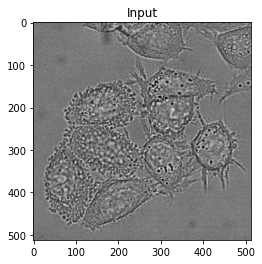

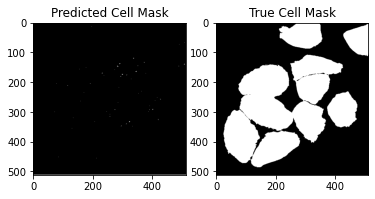

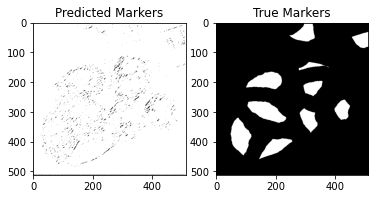

........................................................................................
--- Evaluation ---
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


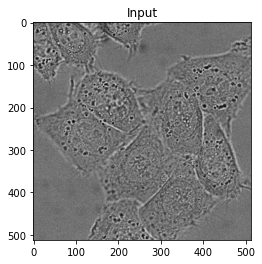

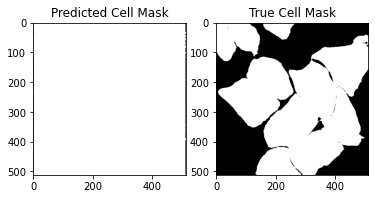

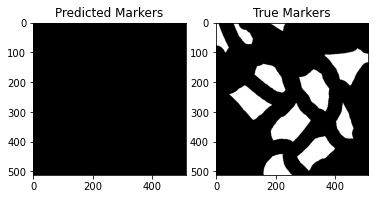

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


NameError: name 'net' is not defined

In [5]:
if __name__ == '__main__':
    main()